# Using Lz and Lxy

The BDT predictive variable Lz and Lxy need to be built into the BDT. They have already been included, and Lxy has been shown to be useful. Lz, however, not so much - it gets dropped when we do variable elimination.

Here we will look at:
- General Characterists of Lx and Lxy to see how they might help us
  - General plot of Lz and Lxy
  - Explore how their effectiveness varies as a function of eta and anything else that seems relevent
- How does a cut on Lxy and Lz affect the training?

## Initalization

In [1]:
from bdt_training_scikit_tools import plot_training_performance, load_default_samples, test_train_samples, prep_samples, default_training, calc_performance, calc_performance_for_run
import matplotlib.pyplot as plt
plt.rc('font', size=14)
from matplotlib.colors import LogNorm
import pandas as pd
import numpy as np

## Load Data Samples

In [2]:
all_events = load_default_samples("90")

BIB: 400000 events
Multijet: 400000 events
Signal: 400000 events


In [3]:
signal = all_events[2]

In [4]:
signal.columns

Index(['RunNumber', 'Weight', 'WeightMCEvent', 'WeightXSection',
       'WeightFlatten', 'mc_Lxy', 'mc_Lz', 'MHTOverHT', 'JetPt', 'JetPhi',
       'CalRatio', 'JetEta', 'NTracks', 'SumPtOfAllTracks', 'MaxTrackPt',
       'EventNumber', 'JetET', 'JetWidth', 'JetDRTo2GeVTrack', 'EnergyDensity',
       'HadronicLayer1Fraction', 'JetLat', 'JetLong', 'FirstClusterRadius',
       'ShowerCenter', 'BIBDeltaTimingM', 'BIBDeltaTimingP', 'PredictedLz',
       'PredictedLxy', 'InteractionsPerCrossing'],
      dtype='object')

## Basic Plots

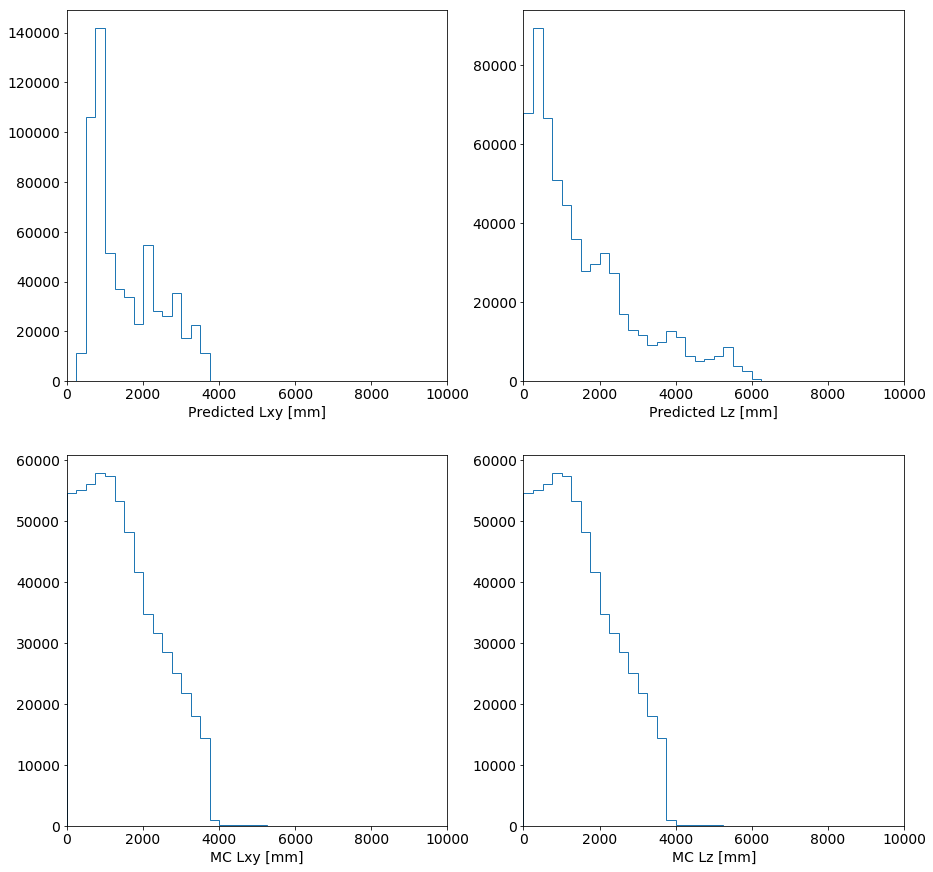

In [74]:
fig = plt.figure(figsize=(15,15))

histargs = {'bins': 40, 'histtype': 'step', 'range': (0, 10000)}

ax = plt.subplot(221)
ax.hist(signal.PredictedLxy, **histargs)
ax.set_xlabel('Predicted Lxy [mm]')
ax.set_xlim(0.0, 10000)

ax = plt.subplot(222)
ax.hist(signal.PredictedLz, **histargs)
ax.set_xlabel('Predicted Lz [mm]')
ax.set_xlim(0.0, 10000)

ax = plt.subplot(223)
ax.hist(signal.mc_Lxy*1000, **histargs)
ax.set_xlabel('MC Lxy [mm]')
ax.set_xlim(0.0, 10000)

ax = plt.subplot(224)
ax.hist(signal.mc_Lz*1000, **histargs)
ax.set_xlabel('MC Lz [mm]')
ax.set_xlim(0.0, 10000)

plt.show()

Clearly, there are some major discrpencies. Explore things like $\eta$ and the like.

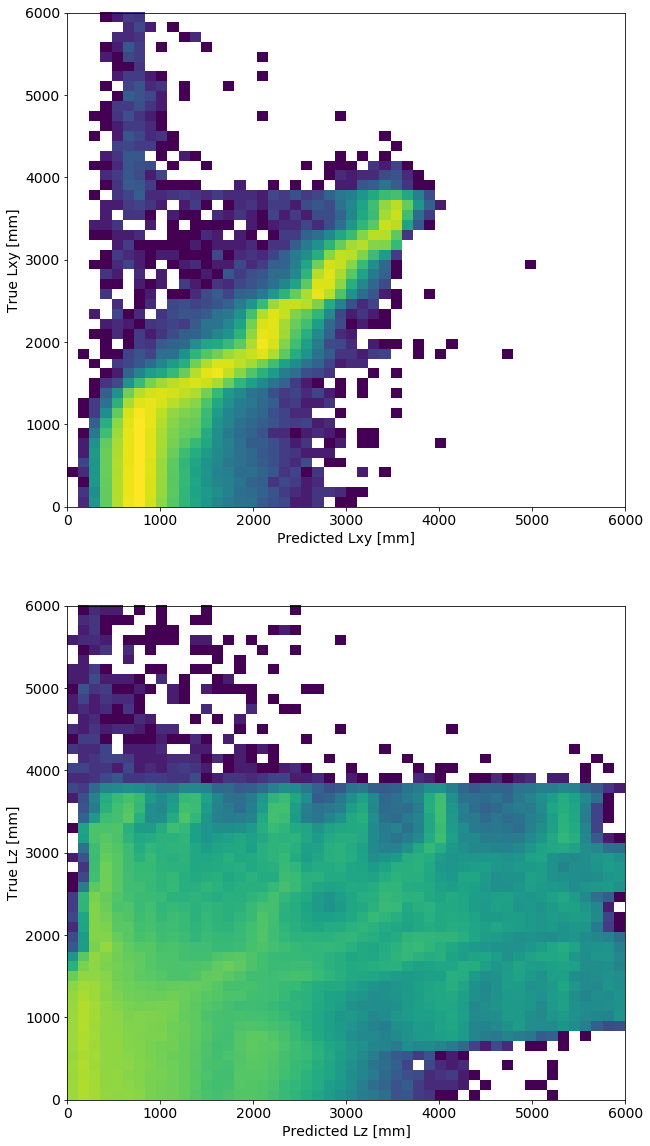

In [73]:
fig = plt.figure(figsize=(10,20))

histargs2d = {'bins':50, 'norm':LogNorm(), 'range': ((0, 6000), (0, 6000))}
ax = plt.subplot(211)
ax.hist2d(signal.PredictedLxy, signal.mc_Lxy*1000, **histargs2d)
ax.set_xlabel('Predicted Lxy [mm]')
ax.set_ylabel('True Lxy [mm]')

ax = plt.subplot(212)
ax.hist2d(signal.PredictedLz, signal.mc_Lz*1000, **histargs2d)
ax.set_xlabel('Predicted Lz [mm]')
ax.set_ylabel('True Lz [mm]')

plt.show()

Look at things as a function of distance from their actual value - see if there is a correlation with $\eta$, for example.

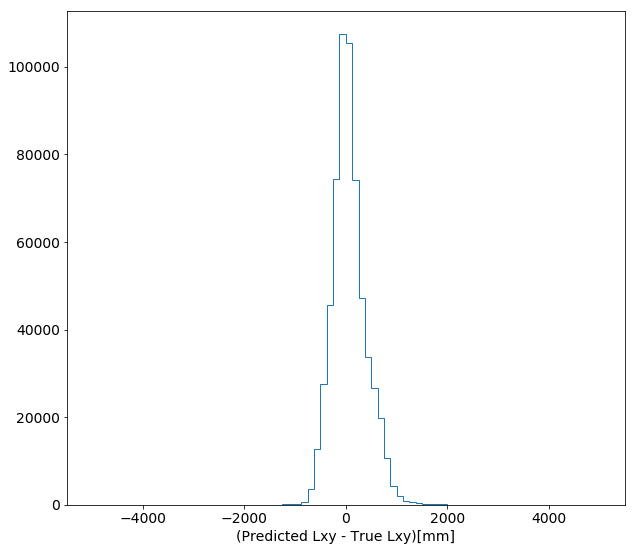

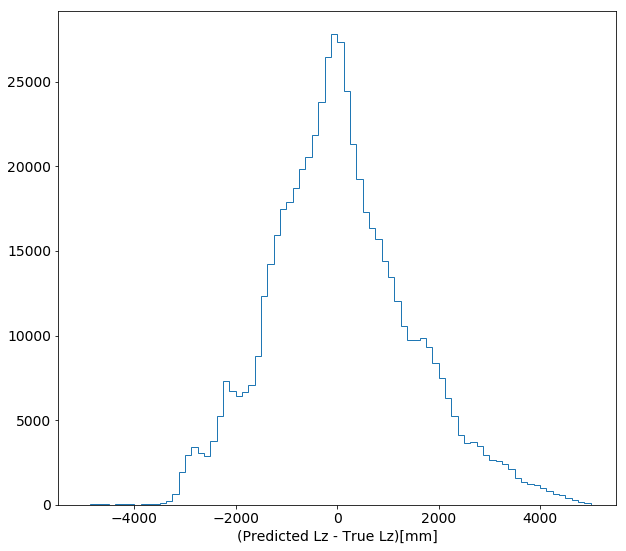

In [63]:
delta_Lxy = signal.PredictedLxy - signal.mc_Lxy*1000
delta_Lz = signal.PredictedLz - signal.mc_Lz*1000

histargs = {'bins': 80, 'histtype': 'step', 'range': (-5000, 5000)}

fig = plt.figure(figsize=(10,20))
ax = plt.subplot(211)
ax.hist(delta_Lxy, **histargs)
ax.set_xlabel('(Predicted Lxy - True Lxy)[mm]')

fig = plt.figure(figsize=(10,20))
ax = plt.subplot(212)
ax.hist(delta_Lz, **histargs)
ax.set_xlabel('(Predicted Lz - True Lz)[mm]')

plt.show()

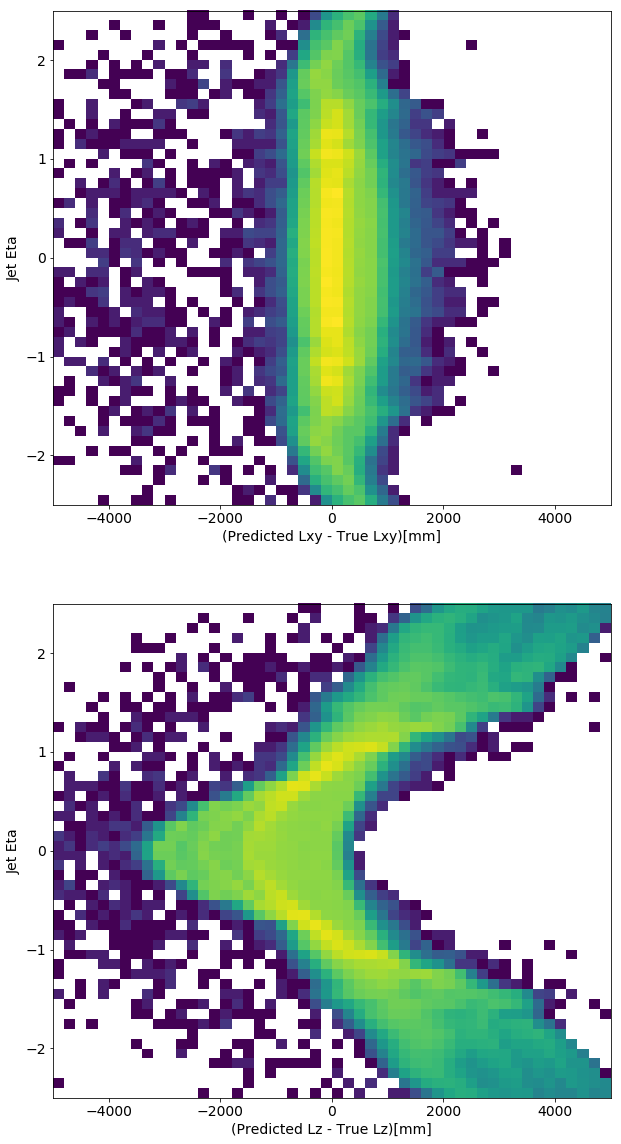

In [65]:
fig = plt.figure(figsize=(10,20))

histargs2d = {'bins':50, 'norm':LogNorm(), 'range': ((-5000, 5000), (-2.5, 2.5))}
ax = plt.subplot(211)
ax.hist2d(delta_Lxy, signal.JetEta, **histargs2d)
ax.set_xlabel('(Predicted Lxy - True Lxy)[mm]')
ax.set_ylabel('Jet Eta')

ax = plt.subplot(212)
ax.hist2d(delta_Lz, signal.JetEta, **histargs2d)
ax.set_xlabel('(Predicted Lz - True Lz)[mm]')
ax.set_ylabel('Jet Eta')

plt.show()

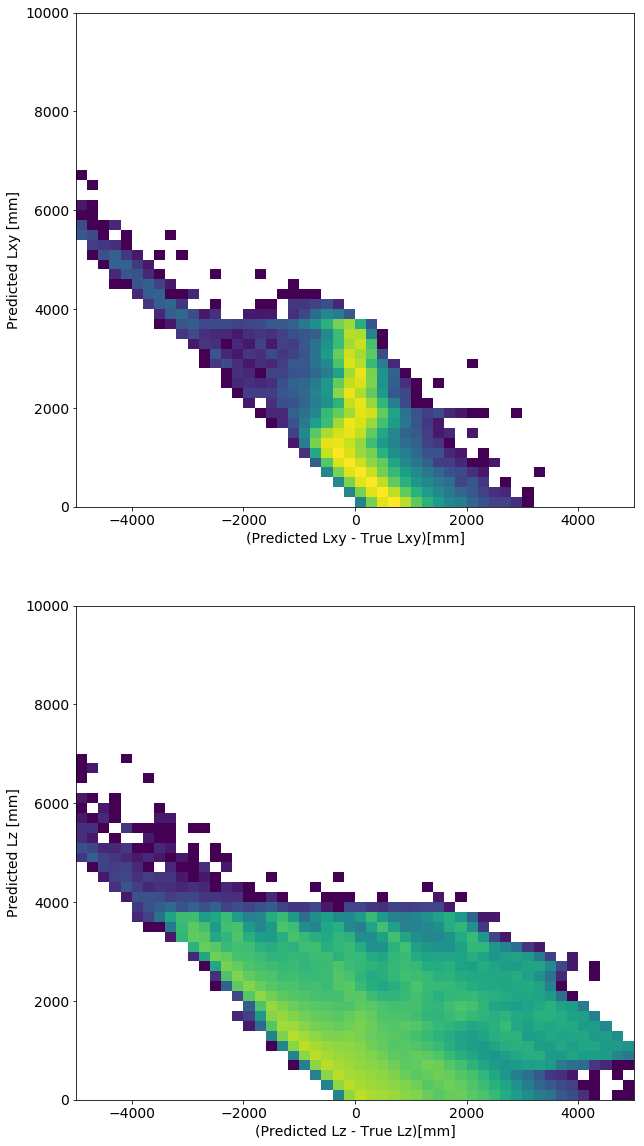

In [69]:
fig = plt.figure(figsize=(10,20))

histargs2d = {'bins':50, 'norm':LogNorm(), 'range': ((-5000, 5000), (0, 10000))}
ax = plt.subplot(211)
ax.hist2d(delta_Lxy, signal.mc_Lxy*1000.0, **histargs2d)
ax.set_xlabel('(Predicted Lxy - True Lxy)[mm]')
ax.set_ylabel('Predicted Lxy [mm]')

ax = plt.subplot(212)
ax.hist2d(delta_Lz, signal.mc_Lz*1000.0, **histargs2d)
ax.set_xlabel('(Predicted Lz - True Lz)[mm]')
ax.set_ylabel('Predicted Lz [mm]')

plt.show()

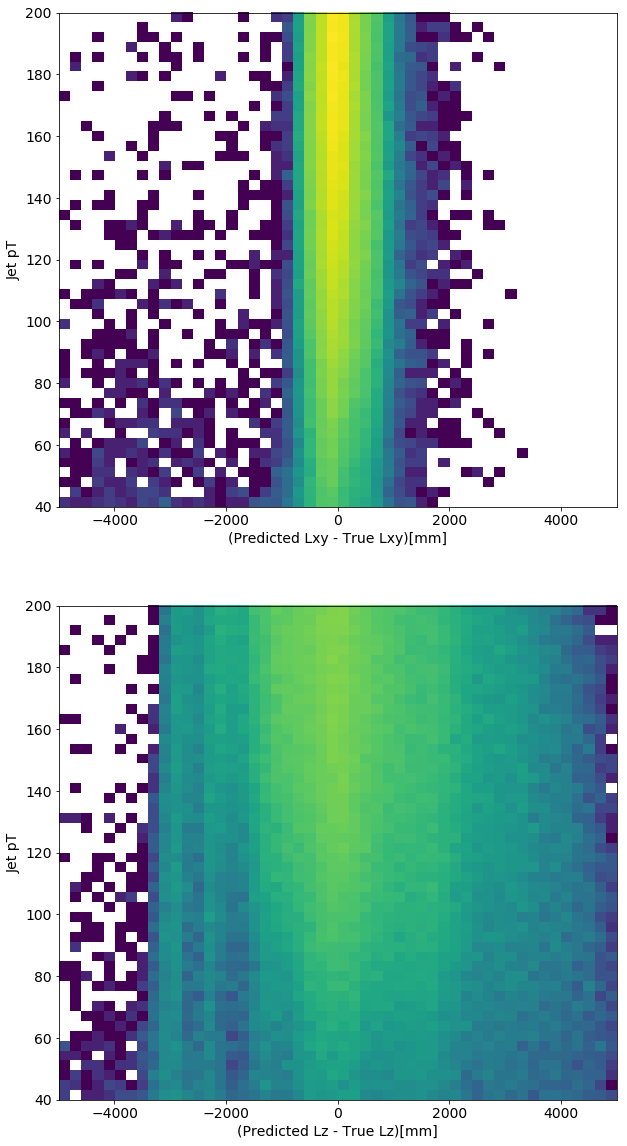

In [68]:
fig = plt.figure(figsize=(10,20))

histargs2d = {'bins':50, 'norm':LogNorm(), 'range': ((-5000, 5000), (40, 200.0))}
ax = plt.subplot(211)
ax.hist2d(delta_Lxy, signal.JetPt, **histargs2d)
ax.set_xlabel('(Predicted Lxy - True Lxy)[mm]')
ax.set_ylabel('Jet pT')

ax = plt.subplot(212)
ax.hist2d(delta_Lz, signal.JetPt, **histargs2d)
ax.set_xlabel('(Predicted Lz - True Lz)[mm]')
ax.set_ylabel('Jet pT')

plt.show()

## Cuts on Lxy and Lz during training
There is evidence that the training is having trouble telling the difference between QCD jets and short-range Lxy and Lz jets... So the question is - what if we trim down on the number of short IP jets in the training?

First thing to be aware here is that we have to split things by eta when we look at them.

In [8]:
forward_eta_cut = 1.4
signal_forward = signal[abs(signal.JetEta)>forward_eta_cut]
signal_central = signal[abs(signal.JetEta)<=forward_eta_cut]

C:\Users\gordo\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


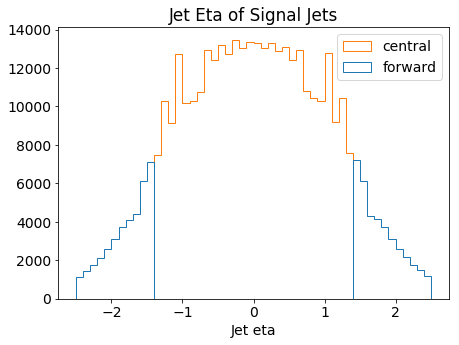

In [25]:
fig = plt.figure(figsize=(7,5))
ax = plt.subplot(111)
ax.hist([signal_forward.JetEta, signal_central.JetEta], bins=50, histtype='step', label=['forward', 'central'])
ax.set_xlabel('Jet eta')
ax.set_title('Jet Eta of Signal Jets')
ax.legend()

plt.show()

Where is a good place to make a cut? For this the real question is as Lxy increasee in the central region, where does the MLP prediction start to pick things up? This is probably the most senstive thing to look at to determine this.

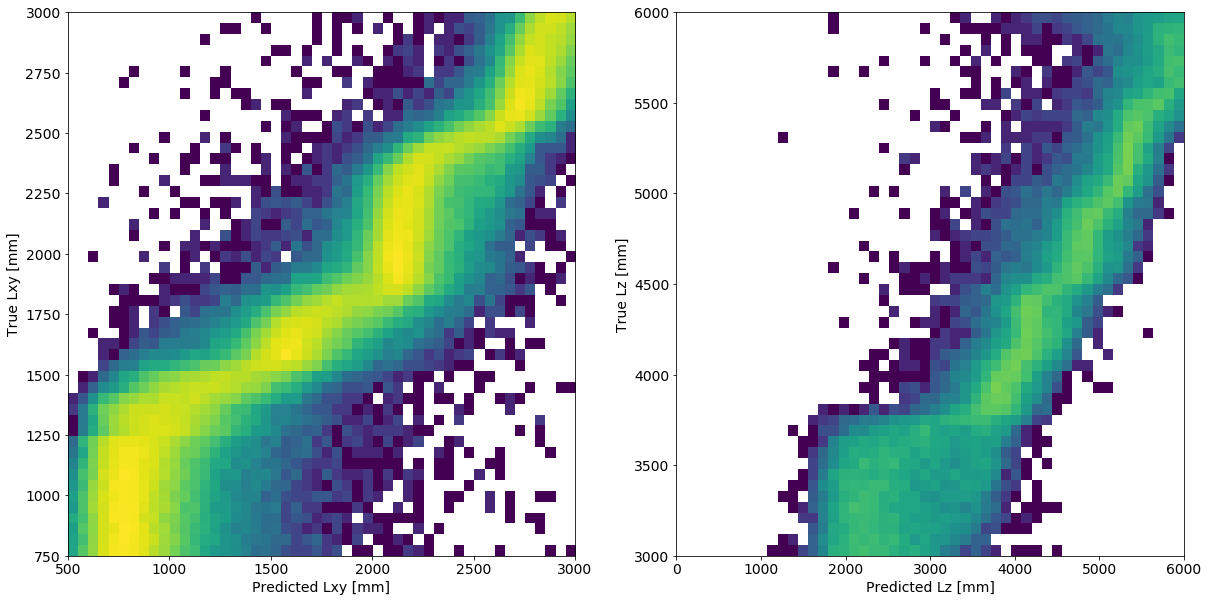

In [36]:
fig = plt.figure(figsize=(20,10))

histargs2d = {'bins':50, 'norm':LogNorm()}
ax = plt.subplot(121)
ax.hist2d(signal_central.PredictedLxy, signal_central.mc_Lxy*1000, range=((500, 3000), (750, 3000)), **histargs2d)
ax.set_xlabel('Predicted Lxy [mm]')
ax.set_ylabel('True Lxy [mm]')

ax = plt.subplot(122)
ax.hist2d(signal_forward.PredictedLz, signal_forward.mc_Lz*1000, range=((0, 6000), (3000, 6000)), **histargs2d)
ax.set_xlabel('Predicted Lz [mm]')
ax.set_ylabel('True Lz [mm]')

plt.show()

In conclusion:

- Lxy: looks like the first evidence of something changing happens at 1250 - there is almost a sharp break. Lets guess around 1000 mm to be safe and see what happens.
- Lx: Around 3750 mm seems to be the break. So, to be safe lets put it at 3500.

In [37]:
cut_lxy = 1000
cut_lz = 3500

In [67]:
def signal_with_dl_cut (signal, cut_lxy, cut_lz, eta_seperator_cut = 1.4):
    '''Return the signal with a decay length cut applied for central and forward regions.
    
    Args:
        signal - the pandas DF that contains our standard signal
        cut_lxy - where we want to make the lxy cut in the central jets. Jets with something shorter won't be here. [mm]
        cut_lz - where we want to make the lz cut for forward jets. [mm]
        eta_seperator_cut - how to tell the diference between central and forward regions.
        
    Returns:
        sig - A signal DF with the cuts applied
    
    '''
    return signal[((abs(signal.JetEta) > eta_seperator_cut) & (signal.mc_Lz*1000 > cut_lz)) | ((abs(signal.JetEta) <= eta_seperator_cut) & (signal.mc_Lxy*1000 > cut_lxy))]
    #fwd_jets = signal[abs(signal.JetEta) > eta_seperator_cut]
    #cen_jets = signal[abs(signal.JetEta) <= eta_seperator_cut]
    
    #good_fwd_jets = fwd_jets[fwd_jets.mc_Lz*1000 > cut_lz]
    #good_cen_jets = cen_jets[cen_jets.mc_Lxy*1000 > cut_lxy]


In [73]:
signal_default_cut = signal_with_dl_cut(signal, cut_lxy, cut_lz)
print (len(signal_default_cut))

244492


Given this sample, run the training and evaulation and look at the result for both skimmed and unskimmed. Our figure of merit is going to have to do with how we calculate bib. So, we'll do the standard calculation and look at that.

In [78]:
def get_mj_weights (bib, mj, signal):
    '''Run a training for our BDT given the three training samples above'''
    
    # Split into testing and training samples
    all_events = (bib, mj, signal)
    train, test = test_train_samples(all_events)
    
    # Prep samples for training
    all_events, all_events_class, training_weight, evaluation_weight = prep_samples(train[0], train[1], train[2])
    
    # Run training
    bdt = default_training(all_events, training_weight, all_events_class)
    
    # Create a thing of all the results
    return calc_performance(default_training(all_events, training_weight, all_events_class), test)

In [79]:
r = get_mj_weights(all_events[0], all_events[1], signal_default_cut)

In [80]:
r2 = get_mj_weights(all_events[0], all_events[1], all_events[2])

In [81]:
r

{'BIBBack': 60261356.754820704,
 'BIBEff': 0.642867899524125,
 'BIBSsqrtB': 10.998324380325949,
 'BIBTotalCount': 132808,
 'BIBTotalWeight': 132808.0,
 'BIBinBIB': 85378.0,
 'BIBinHSS': 4112.0,
 'BIBinMJ': 43318.0,
 'HSSBack': 5557294.051867483,
 'HSSEff': 0.9639894303447428,
 'HSSSsqrtB': 33.27194675252008,
 'HSSTotalCount': 81365,
 'HSSTotalWeight': 81365.0,
 'HSSinBIB': 2492.0,
 'HSSinHSS': 78435.0,
 'HSSinMJ': 438.0,
 'MJBack': 43756.0,
 'MJEff': 0.6383156280752302,
 'MJSsqrtB': 555254.8042971715,
 'MJTotalCount': 133213,
 'MJTotalWeight': 181959885.23490223,
 'MJinBIB': 60258864.754820704,
 'MJinHSS': 5553182.051867483,
 'MJinMJ': 116147838.42821343}

In [82]:
r2

{'BIBBack': 64007564.745797046,
 'BIBEff': 0.654380760195169,
 'BIBSsqrtB': 10.862733036046848,
 'BIBTotalCount': 132808,
 'BIBTotalWeight': 132808.0,
 'BIBinBIB': 86907.0,
 'BIBinHSS': 6478.0,
 'BIBinMJ': 39423.0,
 'HSSBack': 9481329.985270636,
 'HSSEff': 0.9593125954312746,
 'HSSSsqrtB': 41.624111520860694,
 'HSSTotalCount': 133604,
 'HSSTotalWeight': 133604.0,
 'HSSinBIB': 3609.0,
 'HSSinHSS': 128168.0,
 'HSSinMJ': 1827.0,
 'MJBack': 41250.0,
 'MJEff': 0.5961812811861787,
 'MJSsqrtB': 534123.9029196595,
 'MJTotalCount': 133213,
 'MJTotalWeight': 181959885.23490223,
 'MJinBIB': 64003955.745797046,
 'MJinHSS': 9474851.985270636,
 'MJinMJ': 108481077.50383407}